### Team 39 Contributors:
* 20241457 Onni Mansikkamäki
* 20240506 Jan-Louis Schneider
* 20240945 Emir Kamiloglu
* 20240941 Tomás Figueiredo
* 20240661 Rita Santos

In [67]:
%pip install summarytools
%pip install ipywidgets
%pip install annoy
%pip install tensorflow
%pip install imbalanced-learn

from annoy import AnnoyIndex
import phik
import warnings
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
print("StandardScaler imported")
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from summarytools import dfSummary
from math import ceil
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.decomposition import PCA
import scipy.stats as stats 

import joblib

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
StandardScaler imported


In [97]:
#Import the data

with open("claim_injury_type_mapping.json", "r") as file:
    claim_injury_type_mapping = json.load(file)

train_data_standardized = pd.read_csv("train_data_processed_standardized.csv")
train_data_non_standardized = pd.read_csv("train_data_processed_non_standardized.csv")

test_data_standardized = pd.read_csv("test_data_processed_standardized.csv")
test_data_non_standardized = pd.read_csv("test_data_processed_non_standardized.csv")

validation_data_standardized = pd.read_csv("validation_data_processed_standardized.csv")
validation_data_non_standardized = pd.read_csv("validation_data_processed_non_standardized.csv")


In [98]:

# Set Claim Identifier as index for training data and validation data

train_data_standardized.set_index("Claim Identifier", inplace=True)
train_data_non_standardized.set_index("Claim Identifier", inplace=True)

validation_data_standardized.set_index("Claim Identifier", inplace=True)
validation_data_non_standardized.set_index("Claim Identifier", inplace=True)

test_data_standardized.set_index("Claim Identifier", inplace=True)
test_data_non_standardized.set_index("Claim Identifier", inplace=True)


# Map test data index to follow test_data_index.json's index mapping

with open("test_data_index.json", "r") as file:
    test_data_index = json.load(file)

test_data_standardized.index = test_data_index
test_data_non_standardized.index = test_data_index

print(test_data_standardized.index)


Index([6165911, 6166141, 6165907, 6166047, 6166102, 6165787, 6166019, 6166080,
       6165976, 6165953,
       ...
       6553150, 6553838, 6553451, 6553454, 6553140, 6553137, 6553119, 6553542,
       6553455, 6553594],
      dtype='int64', length=387975)


In [99]:
# Check the data
print(train_data_standardized.columns)
train_data_standardized.head()


Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'Carrier Type', 'Claim Injury Type', 'District Name', 'Gender',
       'IME-4 Count', 'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code',
       'Number of Dependents', 'Days Until Injury Reported'],
      dtype='object')


,Accident Date,Age at Injury,Assembly Date,Attorney/Representative,Average Weekly Wage,C-2 Date,Carrier Type,Claim Injury Type,District Name,Gender,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Number of Dependents,Days Until Injury Reported
Claim Identifier,,,,,,,,,,,,,,,,,
6057673,-1.266515,1.158054,-1.223194,0,0.143750,-1.200452,1,2,1,1,-0.419308,92,99,59,53,-0.502881,-0.343428
5918256,-0.641131,0.566319,-0.644960,0,0.076640,-0.626157,2,2,5,1,-0.419308,23,80,40,14,-0.502881,-0.087336
6054143,-1.233121,0.492352,-1.204131,0,-0.559685,-1.181519,2,4,1,2,-0.419308,72,27,52,33,0.997085,-0.290075
6009943,-1.038827,0.492352,-1.023036,1,1.715827,-1.001657,1,4,5,2,2.102156,62,31,10,-9,-1.002870,-0.215382
5627232,0.515527,-1.060955,0.644947,0,-0.841125,0.654962,3,2,2,1,-0.419308,44,32,40,19,0.497096,-0.354098


In [100]:
print(train_data_non_standardized.columns)
train_data_non_standardized.head()

Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'Carrier Type', 'Claim Injury Type', 'District Name', 'Gender',
       'IME-4 Count', 'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code',
       'Number of Dependents', 'Days Until Injury Reported'],
      dtype='object')


,Accident Date,Age at Injury,Assembly Date,Attorney/Representative,Average Weekly Wage,C-2 Date,Carrier Type,Claim Injury Type,District Name,Gender,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Number of Dependents,Days Until Injury Reported
Claim Identifier,,,,,,,,,,,,,,,,,
6057673,848,58,846,0,831.30,846,1,2,1,1,0.0,92,99,59,53,2.0,2
5918256,1054,50,1028,0,790.63,1028,2,2,5,1,0.0,23,80,40,14,2.0,26
6054143,859,49,852,0,405.00,852,2,4,1,2,0.0,72,27,52,33,5.0,7
6009943,923,49,909,1,1784.02,909,1,4,5,2,4.0,62,31,10,-9,1.0,14
5627232,1435,28,1434,0,234.44,1434,3,2,2,1,0.0,44,32,40,19,4.0,1


In [101]:
print(test_data_standardized.columns)
test_data_standardized.head()

Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'Carrier Type', 'District Name', 'Gender', 'IME-4 Count',
       'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code',
       'Number of Dependents', 'Days Until Injury Reported'],
      dtype='object')


,Accident Date,Age at Injury,Assembly Date,Attorney/Representative,Average Weekly Wage,C-2 Date,Carrier Type,District Name,Gender,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Number of Dependents,Days Until Injury Reported
6165911,-1.685462,-1.726657,-1.683875,0,-0.123500,-1.657994,2,5,1,-0.419308,48,31,10,54,-1.002870,-0.268734
6166141,-1.582243,-1.726657,-1.683875,0,-0.800979,-1.657994,2,5,2,-0.419308,45,75,10,10,-1.002870,0.094063
6165907,-1.691533,1.232021,-1.683875,0,-1.227973,-1.651683,2,5,2,-0.419308,56,68,49,62,-1.502859,-0.290075
6166047,-1.697605,0.936153,-1.683875,0,-1.227973,-1.657994,2,5,2,-0.419308,48,25,10,53,1.497074,-0.311416
6166102,-1.673318,-1.282856,-1.683875,0,-1.227973,-1.651683,2,5,1,-0.419308,55,79,40,37,0.997085,-0.226052


In [102]:
print(test_data_non_standardized.columns)
test_data_non_standardized.head()

Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'Carrier Type', 'District Name', 'Gender', 'IME-4 Count',
       'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code',
       'Number of Dependents', 'Days Until Injury Reported'],
      dtype='object')


,Accident Date,Age at Injury,Assembly Date,Attorney/Representative,Average Weekly Wage,C-2 Date,Carrier Type,District Name,Gender,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Number of Dependents,Days Until Injury Reported
6165911,710,19,701,0,669.34,701,2,5,1,0.0,48,31,10,54,1.0,9
6166141,744,19,701,0,258.77,701,2,5,2,0.0,45,75,10,10,1.0,43
6165907,708,59,701,0,0.00,703,2,5,2,0.0,56,68,49,62,0.0,7
6166047,706,55,701,0,0.00,701,2,5,2,0.0,48,25,10,53,6.0,5
6166102,714,25,701,0,0.00,703,2,5,1,0.0,55,79,40,37,5.0,13


In [103]:
print(validation_data_standardized.columns)
validation_data_standardized.head()

Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'Carrier Type', 'Claim Injury Type', 'District Name', 'Gender',
       'IME-4 Count', 'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code',
       'Number of Dependents', 'Days Until Injury Reported'],
      dtype='object')


,Accident Date,Age at Injury,Assembly Date,Attorney/Representative,Average Weekly Wage,C-2 Date,Carrier Type,Claim Injury Type,District Name,Gender,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Number of Dependents,Days Until Injury Reported
Claim Identifier,,,,,,,,,,,,,,,,,
5475505,1.265380,-1.726657,1.416985,0,-0.841125,1.421741,2,2,4,2,-0.419308,44,31,49,55,-0.002892,-0.311416
5717962,0.129974,0.270451,0.228745,1,0.612673,0.241596,3,4,8,1,-0.419308,92,99,10,35,-1.002870,-0.311416
6066275,-1.251336,0.862186,-1.261319,1,1.214495,-1.247784,1,3,5,1,0.211058,92,17,43,-9,-1.502859,-0.162029
5775823,0.600530,0.714253,-0.022246,0,-0.598908,-0.004530,2,3,4,1,-0.419308,56,60,43,35,0.497096,2.185481
5989947,-0.938644,1.084087,-0.937254,0,-0.478154,-0.913304,1,2,5,2,-0.419308,62,56,10,-9,0.997085,-0.151359


In [104]:
print(validation_data_non_standardized.columns)
validation_data_non_standardized.head()

Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'Carrier Type', 'Claim Injury Type', 'District Name', 'Gender',
       'IME-4 Count', 'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code',
       'Number of Dependents', 'Days Until Injury Reported'],
      dtype='object')


,Accident Date,Age at Injury,Assembly Date,Attorney/Representative,Average Weekly Wage,C-2 Date,Carrier Type,Claim Injury Type,District Name,Gender,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Number of Dependents,Days Until Injury Reported
Claim Identifier,,,,,,,,,,,,,,,,,
5475505,1682,19,1677,0,234.44,1677,2,2,4,2,0.0,44,31,49,55,3.0,5
5717962,1308,46,1303,1,1115.48,1303,3,4,8,1,0.0,92,99,10,35,1.0,5
6066275,853,54,834,1,1480.20,831,1,3,5,1,1.0,92,17,43,-9,0.0,19
5775823,1463,52,1224,0,381.23,1225,2,3,4,1,0.0,56,60,43,35,4.0,239
5989947,956,57,936,0,454.41,937,1,2,5,2,0.0,62,56,10,-9,5.0,20


 ### KNN Classifier with PCA to reduce dimensionality of data.

 * Normal KNN, it took so much time that for training, data was sampled from training data in the beginning. Later more data was added to training

 * Approximation of NN calculation was used so that the calculation would be faster

     * Annoy library (Approximate Nearest Neighbors Oh Yeah) was used to get the approximation of the NN

         * Annoy algorithm builds multiple trees for fast approximate neighbor search. A higher number of trees increases accuracy but slows down building of the tree.



In [ ]:
# %%
# #KNN with PCA, data sampling Annoy optimization

# train_data_knn = train_data.copy()
# test_data_knn = test_data.copy()

# # Define the independant variables (as data) and the target variable
# data_knn = train_data_knn.drop(["Claim Injury Type"], axis=1)
# target_knn = train_data_knn["Claim Injury Type"]

# # Split data to X_train, X_test, y_train and y_test
# X_train_knn, X_val_knn, y_train_knn, y_val_knn = train_test_split(data_knn, 
#                                                   target_knn, 
#                                                   test_size = 0.2, 
#                                                   random_state=5, 
#                                                   stratify = target_knn)


# # Sample and reduce dimensionality of the data
# sample_size = 400000
# X_train_knn_sample, _, y_train_knn_sample, _ = train_test_split(X_train_knn, y_train_knn, train_size=sample_size, random_state=42)
# # Determine the number of PC's based on available features or samples
# n_components = min(15, X_train_knn_sample.shape[1])
# pca = PCA(n_components=n_components)
# X_train_knn_reduced = pca.fit_transform(X_train_knn_sample)
# X_val_knn_reduced = pca.transform(X_val_knn)

# # Build Annoy index with reduced data
# index = AnnoyIndex(X_train_knn_reduced.shape[1], 'euclidean')
# for i, vector in enumerate(X_train_knn_reduced):
#     index.add_item(i, vector)
# index.build(10)  # Number of trees in Annoy; higher means better accuracy but slower build


# # Convert y_train_knn_sample to a NumPy array for positional indexing
# y_train_knn_sample = y_train_knn_sample.to_numpy()

# # Function to get predictions using Annoy 
# '''
# Retrieves the indices of the k nearest neighbors for the vector x in X_val. These are approximate neighbors based on the trees built by Annoy.
# '''

# def get_approximate_knn_predictions(X_val, index, y_train, k):
#     predictions = []
#     for x in X_val:
#         nearest_indices = index.get_nns_by_vector(x, k)
#         nearest_labels = [y_train[idx] for idx in nearest_indices]
#         predictions.append(max(set(nearest_labels), key=nearest_labels.count))
#     return predictions

# # Evaluate each range of k values
# k_ranges = {
#     "2-10": range(2, 11),
#     "11-20": range(11, 21),
#     "21-30": range(21, 31)
#     # "100-110": range(100, 111)
# }

# best_k_values = {}
# best_accuracy_scores = {}
# best_f1_scores = {}
# best_predictions = {}

# for label, k_range in k_ranges.items():
#     accuracy_scores = []
#     f1_scores = []
#     high_accuracy = 0
#     best_k = 0
#     best_preds = None
#     best_f1 = 0  # Track F1 score for the best k based on accuracy

#     print(f"Evaluating k values in range: {label}")
    
#     for k in k_range:
#         # Get approximate KNN predictions
#         predictions = get_approximate_knn_predictions(X_val_knn_reduced, index, y_train_knn_sample, k)
        
#         # Calculate accuracy and F1 score
#         accuracy = accuracy_score(y_val_knn, predictions)
#         f1 = f1_score(y_val_knn, predictions, average='weighted')
        
#         accuracy_scores.append(accuracy)
#         f1_scores.append(f1)

#         # Update best k if this model has a higher accuracy
#         if accuracy > high_accuracy:
#             high_accuracy = accuracy
#             best_k = k
#             best_preds = predictions
#             best_f1 = f1  

#     # Store results for this range
#     best_k_values[label] = best_k
#     best_accuracy_scores[label] = high_accuracy
#     best_f1_scores[label] = best_f1
#     best_predictions[label] = best_preds

#     # Plot Accuracy and F1 Score for the current k range
#     plt.figure()
#     plt.plot(list(k_range), accuracy_scores, marker='o', label='Accuracy')
#     plt.plot(list(k_range), f1_scores, marker='x', label='F1 Score')
#     plt.xlabel('Number of Neighbors (k)')
#     plt.ylabel('Score')
#     plt.title(f'Accuracy and F1 Score for k values in Range {label}')
#     plt.legend()
#     plt.show()

#     # Output the best result for the range
#     print(f"Best k in range {label}: {best_k}")
#     print(f"Best Accuracy in range {label}: {high_accuracy}")
#     print(f"F1 Score for best k ({best_k}) in range {label}: {best_f1}")




 # We saw that with k over 21, we are not gaining accuracy or f1 score anymore. Let's now try more interesting k-values under 21 and also see the training data accuracy to see if we are overfitting.



 # We found that training and evaluation accuracy are getting closer to each other without losing val accuracy with under k<20. Let's try also k values over 20 and see if we can reduce overfitting without losing too much f1 score and validation accuracy.

In [ ]:
# %%
# train_data_knn = train_data.copy()
# test_data_knn = test_data.copy()

# # Define the independant variables (as data) and the target variable
# data_knn = train_data_knn.drop(["Claim Injury Type"], axis=1)
# target_knn = train_data_knn["Claim Injury Type"]

# # Split data to X_train, X_test, y_train and y_test

# X_train_knn, X_val_knn, y_train_knn, y_val_knn = train_test_split(data_knn, 
#                                                   target_knn, 
#                                                   test_size = 0.2, 
#                                                   random_state=5, 
#                                                   stratify = target_knn)

# # Sample and reduce dimensionality of the data
# sample_size = 400000
# X_train_knn_sample, _, y_train_knn_sample, _ = train_test_split(X_train_knn, y_train_knn, train_size=sample_size, random_state=42)
# pca = PCA(n_components=min(15, X_train_knn_sample.shape[1]))  # Adjusting PCA components as needed
# X_train_knn_reduced = pca.fit_transform(X_train_knn_sample)
# X_val_knn_reduced = pca.transform(X_val_knn)

# # Convert y_train_knn_sample to a NumPy array for reliable indexing
# y_train_knn_sample = y_train_knn_sample.to_numpy()

# #  Build Annoy index with reduced data
# index = AnnoyIndex(X_train_knn_reduced.shape[1], 'euclidean')
# for i, vector in enumerate(X_train_knn_reduced):
#     index.add_item(i, vector)
# index.build(10)  

# # Function to get predictions using Annoy
# def get_approximate_knn_predictions(X_val, index, y_train, k):
#     predictions = []
#     for x in X_val:
#         nearest_indices = index.get_nns_by_vector(x, k)
#         nearest_labels = [y_train[idx] for idx in nearest_indices]
#         predictions.append(max(set(nearest_labels), key=nearest_labels.count))
#     return predictions

# # Evaluate each range of k values

# k_ranges = {
#     "2-10": range(2, 11),
#     "11-20": range(11, 21),
#     "21-40": range(21, 41),
# }

# best_k_values = {}
# best_accuracy_scores = {}
# best_f1_scores = {}
# best_predictions = {}

# for label, k_range in k_ranges.items():
#     accuracy_scores_train = []
#     accuracy_scores_val = []
#     f1_scores = []
#     high_accuracy = 0
#     best_k = 0
#     best_preds = None
#     best_f1 = 0  # Track F1 score for the best k based on validation accuracy

#     print(f"Evaluating k values in range: {label}")
    
#     for k in k_range:
#         # Get predictions and accuracy for the validation data
#         predictions_val = get_approximate_knn_predictions(X_val_knn_reduced, index, y_train_knn_sample, k)
#         accuracy_val = accuracy_score(y_val_knn, predictions_val)
#         f1_val = f1_score(y_val_knn, predictions_val, average='weighted')

#         # Get predictions and accuracy for the training data
#         predictions_train = get_approximate_knn_predictions(X_train_knn_reduced, index, y_train_knn_sample, k)
#         accuracy_train = accuracy_score(y_train_knn_sample, predictions_train)

#         # Store training and validation accuracy and F1 score
#         accuracy_scores_train.append(accuracy_train)
#         accuracy_scores_val.append(accuracy_val)
#         f1_scores.append(f1_val)

#         # Update best k if this model has a higher validation accuracy
#         if accuracy_val > high_accuracy:
#             high_accuracy = accuracy_val
#             best_k = k
#             best_preds = predictions_val
#             best_f1 = f1_val  # Store the F1 score for the best accuracy on validation data

#     # Store results for this range
#     best_k_values[label] = best_k
#     best_accuracy_scores[label] = high_accuracy
#     best_f1_scores[label] = best_f1
#     best_predictions[label] = best_preds

#     # Plot Accuracy (Train and Validation) and F1 Score for the current k range
#     plt.figure()
#     plt.plot(list(k_range), accuracy_scores_train, marker='o', label='Training Accuracy')
#     plt.plot(list(k_range), accuracy_scores_val, marker='x', label='Validation Accuracy')
#     plt.plot(list(k_range), f1_scores, marker='^', label='Validation F1 Score')
#     plt.xlabel('Number of Neighbors (k)')
#     plt.ylabel('Score')
#     plt.title(f'Accuracy and F1 Score for k values in Range {label}')
#     plt.legend()
#     plt.show()

#     # Output the best result for the range
#     print(f"Best k in range {label}: {best_k}")
#     print(f"Best Validation Accuracy in range {label}: {high_accuracy}")
#     print(f"F1 Score for best k ({best_k}) in range {label}: {best_f1}")
#     print(f"Training Accuracy for best k ({best_k}) in range {label}: {accuracy_scores_train[k_range.index(best_k)]}")




 ## Best K taking accuracy in both val and test set in account seems to be k=35. Even though training accuracy is dropping, the overfitting is reduced with higher k. Validation performance is staying quite consistent with higher k and f1 is not dropping significantly. Later in optimization we might want to oversample training data that has the minority class value of the traget variable. Now our model is probably not good in classification of those minority target variable class rows.



 ## Even though best validation accuracy is found with k=24, I prefer to have better generalizing model (less overfitting) than only 0.1% better validation accuracy. Higher k than 35 is not chosen due to efficiency reasons at this point. Maybe later with more time in our hands we could go for higher k.



 ## Even with k=35, model is slightly overfitting still.

In [ ]:
# %%
# # Transform the test data with PCA
# X_test_knn_reduced = pca.transform(test_data_knn) 

# # Make predictions on the transformed test data using the best k value
# best_k = 35 # Replace with the range key that had the best k (35)
# test_predictions = get_approximate_knn_predictions(X_test_knn_reduced, index, y_train_knn_sample, best_k)



In [ ]:
# %%

# test_predictions = [int(pred) for pred in test_predictions]

# print(test_predictions)
# print(claim_injury_type_mapping)

# # Format the predictions according to the required label format

# # # Convert numerical predictions to the required string format using label mapping
# formatted_predictions = [claim_injury_type_mapping[pred] for pred in test_predictions]

# formatted_predictions

# # # Create the submission DataFrame
# submission = pd.DataFrame({
#     "Claim Identifier": test_data.index,
#     "Claim Injury Type": formatted_predictions
# })

# submission.head()
# # # Save to CSV in the required format
# submission.to_csv("model1.csv", index=False)

# print("Submission file created: model1.csv")


 ## Experiment with standardization for also categorial predictor variables (MODEL FOR BEST KAGGLE RESULT)

In [ ]:
# %%
# train_data_knn = train_data_non_standardized.copy()
# test_data_knn = test_data_non_standardized.copy()

# # Get all columns from the train data which are not the target variable
# predictor_cols = train_data_knn.columns[train_data_knn.columns != "Claim Injury Type"]

# # Initialize the StandardScaler
# scaler = StandardScaler()
# scaler.fit(train_data_knn[predictor_cols])

# # Scale the columns in both train and test data
# train_data_knn[predictor_cols] = scaler.transform(train_data_knn[predictor_cols])
# test_data_knn[predictor_cols] = scaler.transform(test_data_knn[predictor_cols])


# # Define the independant variables (as data) and the target variable
# data_knn = train_data_knn.drop(["Claim Injury Type"], axis=1)
# target_knn = train_data_knn["Claim Injury Type"]

# # Split data to X_train, X_test, y_train and y_test
# X_train_knn, X_val_knn, y_train_knn, y_val_knn = train_test_split(data_knn, 
#                                                   target_knn, 
#                                                   test_size = 0.2, 
#                                                   random_state=5, 
#                                                   stratify = target_knn)

# # Sample and reduce dimensionality of the data
# sample_size = 400000
# X_train_knn_sample, _, y_train_knn_sample, _ = train_test_split(X_train_knn, y_train_knn, train_size=sample_size, random_state=42)
# pca = PCA(n_components=min(15, X_train_knn_sample.shape[1]))  # Adjusting PCA components as needed
# X_train_knn_reduced = pca.fit_transform(X_train_knn_sample)
# X_val_knn_reduced = pca.transform(X_val_knn)

# # Convert y_train_knn_sample to a NumPy array for reliable indexing
# y_train_knn_sample = y_train_knn_sample.to_numpy()

# #  Build Annoy index with reduced data
# index = AnnoyIndex(X_train_knn_reduced.shape[1], 'euclidean')
# for i, vector in enumerate(X_train_knn_reduced):
#     index.add_item(i, vector)
# index.build(10)  

# # Function to get predictions using Annoy
# def get_approximate_knn_predictions(X_val, index, y_train, k):
#     predictions = []
#     for x in X_val:
#         nearest_indices = index.get_nns_by_vector(x, k)
#         nearest_labels = [y_train[idx] for idx in nearest_indices]
#         predictions.append(max(set(nearest_labels), key=nearest_labels.count))
#     return predictions

# # Evaluate each range of k values
# k_ranges = {
#     "30-40": range(30, 41),
# }

# best_k_values = {}
# best_accuracy_scores = {}
# best_f1_scores = {}
# best_predictions = {}

# for label, k_range in k_ranges.items():
#     accuracy_scores_train = []
#     accuracy_scores_val = []
#     f1_scores = []
#     high_accuracy = 0
#     best_k = 0
#     best_preds = None
#     best_f1 = 0  # Track F1 score for the best k based on validation accuracy

#     print(f"Evaluating k values in range: {label}")
    
#     for k in k_range:
#         # Get predictions and accuracy for the validation data
#         predictions_val = get_approximate_knn_predictions(X_val_knn_reduced, index, y_train_knn_sample, k)
#         accuracy_val = accuracy_score(y_val_knn, predictions_val)
#         f1_val = f1_score(y_val_knn, predictions_val, average='weighted')

#         # Get predictions and accuracy for the training data
#         predictions_train = get_approximate_knn_predictions(X_train_knn_reduced, index, y_train_knn_sample, k)
#         accuracy_train = accuracy_score(y_train_knn_sample, predictions_train)

#         # Store training and validation accuracy and F1 score
#         accuracy_scores_train.append(accuracy_train)
#         accuracy_scores_val.append(accuracy_val)
#         f1_scores.append(f1_val)

#         # Update best k if this model has a higher validation accuracy
#         if accuracy_val > high_accuracy:
#             high_accuracy = accuracy_val
#             best_k = k
#             best_preds = predictions_val
#             best_f1 = f1_val  # Store the F1 score for the best accuracy on validation data

#     # Store results for this range
#     best_k_values[label] = best_k
#     best_accuracy_scores[label] = high_accuracy
#     best_f1_scores[label] = best_f1
#     best_predictions[label] = best_preds

#     # Plot Accuracy (Train and Validation) and F1 Score for the current k range
#     plt.figure()
#     plt.plot(list(k_range), accuracy_scores_train, marker='o', label='Training Accuracy')
#     plt.plot(list(k_range), accuracy_scores_val, marker='x', label='Validation Accuracy')
#     plt.plot(list(k_range), f1_scores, marker='^', label='Validation F1 Score')
#     plt.xlabel('Number of Neighbors (k)')
#     plt.ylabel('Score')
#     plt.title(f'Accuracy and F1 Score for k values in Range {label}')
#     plt.legend()
#     plt.show()

#     # Output the best result for the range
#     print(f"Best k in range {label}: {best_k}")
#     print(f"Best Validation Accuracy in range {label}: {high_accuracy}")
#     print(f"F1 Score for best k ({best_k}) in range {label}: {best_f1}")
#     print(f"Training Accuracy for best k ({best_k}) in range {label}: {accuracy_scores_train[k_range.index(best_k)]}")



 ## Best k seems to be 37 in this case from range 30 to 40.



In [ ]:
# %%
# # Transform the test data with PCA
# X_test_knn_reduced = pca.transform(test_data_knn) 

# # Make predictions on the transformed test data using the best k value
# best_k = 37 # Replace with the range key that had the best k (37)
# test_predictions = get_approximate_knn_predictions(X_test_knn_reduced, index, y_train_knn_sample, best_k)

# test_predictions = [int(pred) for pred in test_predictions]

# # Format the predictions according to the required label format

# # # Convert numerical predictions to the required string format using label mapping
# formatted_predictions = [claim_injury_type_mapping[pred] for pred in test_predictions]

# formatted_predictions

# # # Create the submission DataFrame
# submission = pd.DataFrame({
#     "Claim Identifier": test_data.index,
#     "Claim Injury Type": formatted_predictions
# })

# submission.head()
# # # Save to CSV in the required format
# submission.to_csv("model4.csv", index=False)

# print("Submission file created: model4.csv")


 ### Optimizations and results

 * **Increase training data points (from sample of 50 000 to all of the data)**

     * With 50 000 samples of training data

         * **We got f1 score of 0.23926 in Kaggle**

         * Best k in range 10-30 was k=20

         * Best Validation Accuracy for k=20, 0.56

         * F1 Score (for validation data) for k=20: 0.49

         * Training data Accuracy for k = 20: 0.59382

     * Increasing the sample size of training data for training to be 400 000 (sample of 400 000 to all of the data)

         * **We got f1 score of 0.26029 in Kaggle**

         * Best k in range 10-40 was k=35

         * Best Validation Accuracy for k=35, approx. 0.595

         * F1 Score (for validation data) for k=35: 0.5375

         * Training data Accuracy for k = 35: 0.6175



 * **Scale categorial features as well**

     * Let's use standardization to also standardize the categorial values instead of only metric columns.

         * We will experience this with size of training data as 400 000 (sample of 400 000 to all of the data)

         * Let's try 10 different k values around the k=35 (so from k=30 to k=40)

         * Results:

             * **We got f1 score of 0.27128 in Kaggle**

             * Best k in range 30-40: 37

             * Best Validation Accuracy k=37: 0.648

             * F1 Score for k=37: 0.591

             * Training Accuracy for k=37 in range 30-40: 0.659315



 ### Future optimizations for project part 2

 * **Let go more features**

     * Get rid of highly correlating features with each other (WCIO... features)

     * Add Average Weekly Wage as it might be important

     * Try optimal features from LogisticRegression's RFE.

     * Implement KNNClassifier with RFE

 * Oversample minority target variable values

 * Different PCA values or without PCA

 * Weighting closer neighbors more

 * KFold

 ## Testing of almost random Classifier

 * Just for fun of it, random classifier was used. Guessing was weighted to favor most usual value in target variable in training data. Only other value we allowed the model to guess was the second most usual value in target variable in training data.



 ## Result: Bad as expected

 * In kaggle, f1 score of 0.13 was achieved

In [ ]:
# %%
# NOTE: Commented out since this is not needed for achieving our final results

# Find two most usual target values
# print(train_data['Claim Injury Type'].value_counts())

# Check label mapping
# print(claim_injury_type_mapping)

# Take the Claim Identifier numbers from model1.csv
# model1 = pd.read_csv('model1.csv')
# print(model1['Claim Identifier'])

# # Make a new submission file (model2.csv) with the two most usual target values randomly assigned for every Claim Identifier in model1.csv wtih more ephasis for the most usual value


# # Create a list of the two most usual target values
# most_usual_values = [0, 1]

# # Generate random guesses with weighted probabilities

# # Define the probabilities for each value
# probabilities = [0.8, 0.2]


# print(label_mapping)

# # Generate random guesses
# random_guesses = np.random.choice(most_usual_values, size=len(model1), p=probabilities)

# # Create a new DataFrame for the submission
# submission_model2 = pd.DataFrame({
#     'Claim Identifier': model1['Claim Identifier'],
#     'Claim Injury Type': random_guesses
# })

# # Map the values in submission_model2 'Claim Injury Type' to match the original target values in label_mapping
# submission_model2['Claim Injury Type'] = submission_model2['Claim Injury Type'].map(label_mapping)
# print(submission_model2)


# # Save the new submission file
# submission_model2.to_csv('model3.csv', index=False)




 # Things to  consider when optimizing models in deliverable 2



 ## Add Average Weekly Wage back with proper null value imputations



 ## These columns show low correlation with the target variable. Consider training models with and without them to see if they affect accuracy, precision and f1-score

 * District Name

 * Gender

 * Carrier type

 * Number of Dependents



 ## These columns showed high correlation between each other. Consider dropping one or two of them

 * WCIO Cause of Injury Code, WCIO Nature of Injury Code and WCIO Part Of Body Code had high correlations between each other AND nice correlations between target variable.

     * We can consider droppig one or two of these to avoid redundancy



 ## Scaling

 * Try to also change z-score scaling to min-max scaling and see if it affects the accuracy of the model

 * Experience with scaling only numerical values and both numerical and categorial values



 ## Outliers

 * See if thresholding the days until injury reported -feature's values to even lower max-value affects the model accuracy





 ## Keep in mind, the unbalance of the target variable categories. If model performance is not good, try oversampling the rows with minority Claim Injury Type values or try SMOTE

 Claim Injury Type

 - 2. NON-COMP        0.510175

 - 4. TEMPORARY       0.257070

 - 3. MED ONLY        0.121362

 - 5. PPD SCH LOSS    0.084481

 - 1. CANCELLED       0.018900

 - 6. PPD NSL         0.007112

 - 8. DEATH           0.000775

 - 7. PTD             0.000126

 # OPTIMIZATIONS ON KNNCLASSIFIER

In [ ]:
# %%
#NOTE / TODO: START FROM PCA ANALYSIS WHAT WAS DONE IN DM LAB 08!! CHOOSE HOW MANY PCA's TO KEEP

# Some heuristics (rules of thumb):

# Reference: **Jolliffe, I. T. (2002). Principal component analysis.**

# Section 6.1: *How Many Principal Components?*

# - 6.1.1. Cumulative percentage of total variance
#     - Keep 70-80% of total variance
# - 6.1.2. Kaiser's rule
#     - Keep PC with variance >= 1
# - 6.1.3. Scree plot
    # - Use elbow method


# FROM DM LAB 08

# # Get PCA output as table

# # Get the eigenvalues (explained variance)
# explained_variance = pca.explained_variance_

# # Get the explained variance ratio
# explained_variance_ratio = pca.explained_variance_ratio_

# # get the cumulative explained variance ratio 
# # Hint: use np.cumsum()
# cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# # Combine into a dataframe
# pca_results = pd.DataFrame(
#     {
#         "Eigenvalue": explained_variance,
#         "Difference": np.insert(np.diff(explained_variance), 0, 0),
#         "Proportion": explained_variance_ratio,
#         "Cumulative": cumulative_explained_variance_ratio
#     },
#         index=range(1, pca.n_components_ + 1)
# )

# pca_results




 # DEEP NEURAL NETWORK MODEL TRAINING AND OPTIMIZATION

/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 1
Selected features:  Index(['Attorney/Representative'], dtype='object')
Training Accuracy: 0.6212234118454462
Validation Accuracy: 0.6215481721749803
Validation F1 Score: 0.5364665509273919
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 2
Selected features:  Index(['Attorney/Representative', 'IME-4 Count'], dtype='object')
Training Accuracy: 0.6375721116277806
Validation Accuracy: 0.637345489611642
Validation F1 Score: 0.5743071383217663
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 3
Selected features:  Index(['Attorney/Representative', 'Gender', 'IME-4 Count'], dtype='object')
Training Accuracy: 0.6377238659759956
Validation Accuracy: 0.6381169457350749
Validation F1 Score: 0.5712768131716494
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 4
Selected features:  Index(['Attorney/Representative', 'Average Weekly Wage', 'Gender',
       'IME-4 Count'],
      dtype='object')
Training Accuracy: 0.7288580145548275
Validation Accuracy: 0.724581397387569
Validation F1 Score: 0.6620730293612487
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 5
Selected features:  Index(['Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Gender', 'IME-4 Count'],
      dtype='object')
Training Accuracy: 0.7283325368117544
Validation Accuracy: 0.7237222757955641
Validation F1 Score: 0.6615552227316652
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 6
Selected features:  Index(['Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'C-2 Date', 'Gender', 'IME-4 Count'],
      dtype='object')
Training Accuracy: 0.7384661032880864
Validation Accuracy: 0.7324975891996143
Validation F1 Score: 0.6730096937514206
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 7
Selected features:  Index(['Accident Date', 'Assembly Date', 'Attorney/Representative',
       'Average Weekly Wage', 'C-2 Date', 'Gender', 'IME-4 Count'],
      dtype='object')
Training Accuracy: 0.7378817357979447
Validation Accuracy: 0.7326729201367581
Validation F1 Score: 0.6692409853741321
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 8
Selected features:  Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date', 'Gender',
       'IME-4 Count'],
      dtype='object')
Training Accuracy: 0.7309123607314106
Validation Accuracy: 0.7219864995178399
Validation F1 Score: 0.6700172593704894
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 9
Selected features:  Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date', 'Gender',
       'IME-4 Count', 'Days Until Injury Reported'],
      dtype='object')
Training Accuracy: 0.7389576061770815
Validation Accuracy: 0.7350048216007714
Validation F1 Score: 0.6752223566856353
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 10
Selected features:  Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'Carrier Type', 'Gender', 'IME-4 Count', 'Days Until Injury Reported'],
      dtype='object')
Training Accuracy: 0.7393720993968331
Validation Accuracy: 0.7357587446304901
Validation F1 Score: 0.6775669434513728
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 11
Selected features:  Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'Carrier Type', 'District Name', 'Gender', 'IME-4 Count',
       'Days Until Injury Reported'],
      dtype='object')
Training Accuracy: 0.7340629621995773
Validation Accuracy: 0.7307530463750329
Validation F1 Score: 0.6727087012130296
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 12
Selected features:  Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'Carrier Type', 'District Name', 'Gender', 'IME-4 Count',
       'Industry Code', 'Days Until Injury Reported'],
      dtype='object')
Training Accuracy: 0.7542394955413666
Validation Accuracy: 0.7503550451477163
Validation F1 Score: 0.692244675618988
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 13
Selected features:  Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'Carrier Type', 'District Name', 'Gender', 'IME-4 Count',
       'Industry Code', 'WCIO Nature of Injury Code',
       'Days Until Injury Reported'],
      dtype='object')
Training Accuracy: 0.7476846136945842
Validation Accuracy: 0.7439203997545367
Validation F1 Score: 0.6852801270665955
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 14
Selected features:  Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'Carrier Type', 'District Name', 'Gender', 'IME-4 Count',
       'Industry Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code',
       'Days Until Injury Reported'],
      dtype='object')
Training Accuracy: 0.7599676559389178
Validation Accuracy: 0.7552993775751732
Validation F1 Score: 0.6988094170238628
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 15
Selected features:  Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'Carrier Type', 'District Name', 'Gender', 'IME-4 Count',
       'Industry Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code',
       'Number of Dependents', 'Days Until Injury Reported'],
      dtype='object')
Training Accuracy: 0.7567853446069449
Validation Accuracy: 0.7517401595511528
Validation F1 Score: 0.6942116585717297
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


Number of features: 16
Selected features:  Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'Carrier Type', 'District Name', 'Gender', 'IME-4 Count',
       'Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code',
       'Number of Dependents', 'Days Until Injury Reported'],
      dtype='object')
Training Accuracy: 0.7611771607440946
Validation Accuracy: 0.7563601297448935
Validation F1 Score: 0.6985573768792933
--------------------------------------------------


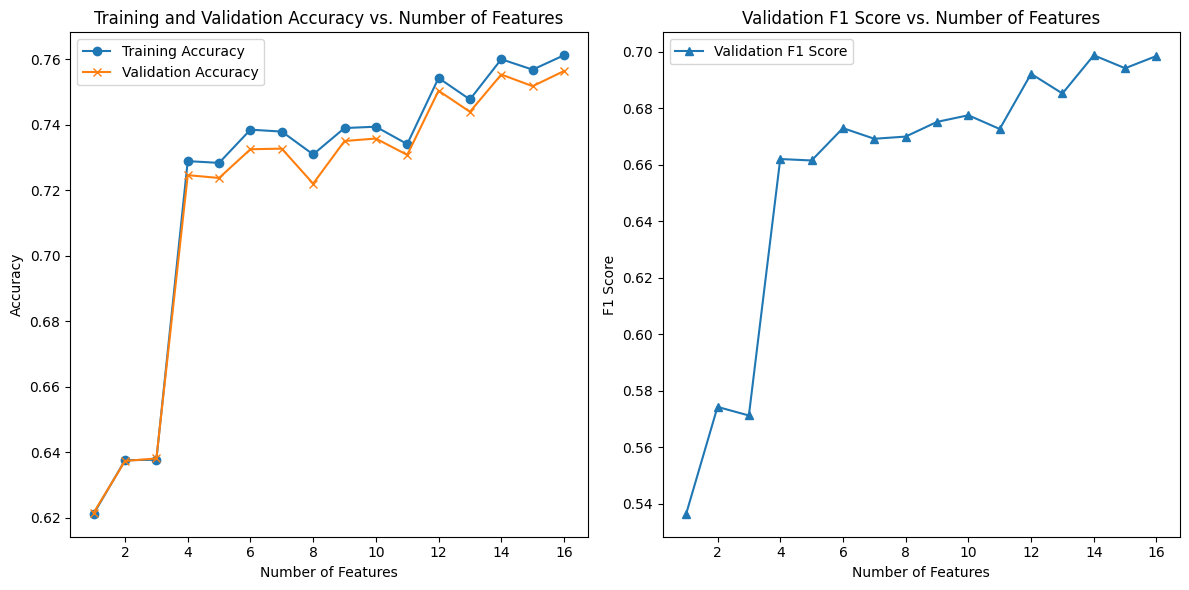

In [23]:
# %%
train_data_NN = train_data_standardized.copy()
val_data_NN = validation_data_standardized.copy()
test_data_NN = test_data_standardized.copy()

# Prepare the data
predictor_cols = train_data_NN.columns[train_data_NN.columns != "Claim Injury Type"]
X_train = train_data_NN[predictor_cols]
y_train = train_data_NN["Claim Injury Type"]

X_val = val_data_NN[predictor_cols]
y_val = val_data_NN["Claim Injury Type"]

# Define the total number of features in the dataset
num_features = X_train.shape[1]

# Lists to store the results for plotting
accuracy_scores_train = []
accuracy_scores_val = []
f1_scores_val = []
num_feature_list = list(range(1, num_features + 1))

# Use LogisticRegression as the base estimator for RFE
base_estimator = LogisticRegression(max_iter=1500)  

# Loop over feature numbers from 1 to the total number of features
for n_features in num_feature_list:
    # Use RFE to select n_features
    rfe = RFE(estimator=base_estimator, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    selected_features = rfe.support_

    # Select the features from training and validation sets
    X_train_rfe = X_train.iloc[:, selected_features]
    X_val_rfe = X_val.iloc[:, selected_features]
    
    # Build the MLPClassifier with a deep structure and small hidden layers
    mlp = MLPClassifier(
        hidden_layer_sizes=(32, 16, 16, 8, 8, 4),  # Deep structure with gradually decreasing sizes
        activation='relu',
        solver='adam',
        max_iter=150  # Increase this if convergence warnings appear (UPDATE: THIS WAS 90 AND I GOT CONVERGING ERRORS)
    )

    # Train the MLP model
    mlp.fit(X_train_rfe, y_train)

    # Evaluate on training data
    train_preds = mlp.predict(X_train_rfe)
    accuracy_train = accuracy_score(y_train, train_preds)

    # Evaluate on validation data
    val_preds = mlp.predict(X_val_rfe)
    accuracy_val = accuracy_score(y_val, val_preds)
    f1_val = f1_score(y_val, val_preds, average='weighted')

    # Store results
    accuracy_scores_train.append(accuracy_train)
    accuracy_scores_val.append(accuracy_val)
    f1_scores_val.append(f1_val)

    # Get selected feature names
    selected_features_names = X_train.columns[selected_features]
    # Print results for each feature set
    print(f"Number of features: {n_features}")
    print("Selected features: ", selected_features_names)
    print(f"Training Accuracy: {accuracy_train}")
    print(f"Validation Accuracy: {accuracy_val}")
    print(f"Validation F1 Score: {f1_val}")
    print("-" * 50)

# Plotting accuracy and F1 scores for different feature counts
plt.figure(figsize=(12, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(num_feature_list, accuracy_scores_train, label='Training Accuracy', marker='o')
plt.plot(num_feature_list, accuracy_scores_val, label='Validation Accuracy', marker='x')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Number of Features')
plt.legend()

# Plot Validation F1 Score
plt.subplot(1, 2, 2)
plt.plot(num_feature_list, f1_scores_val, label='Validation F1 Score', marker='^')
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score vs. Number of Features')
plt.legend()

plt.tight_layout()
plt.show()




 ## NN Model


 ### Train three models with two most promising set of features  and make predictions to test data with them

 * Set of features chosen are:

     * 4 features 
        *  This set was chosen, since after this, we didn't reach significantly better results with adding more features.
        * Selected features:  Index(['Attorney/Representative', 'Average Weekly Wage', 'Gender',
       'IME-4 Count'],
      dtype='object')
        * Training Accuracy: 0.7288580145548275
        * Validation Accuracy: 0.724581397387569
        * Validation F1 Score: 0.6620730293612487

     *  12 features 
        * This set was chosen, since it has the next significant pump in accuracy and in f1-score after 4 features.

        * Selected features:  Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'Carrier Type', 'District Name', 'Gender', 'IME-4 Count',
       'Industry Code', 'Days Until Injury Reported'],
      dtype='object')
        * Training Accuracy: 0.7542394955413666
        * Validation Accuracy: 0.7503550451477163
        * Validation F1 Score: 0.692244675618988
    
    *  14 features 
        * This set was chosen, since it has the highest validation data f1-score

        * Selected features:  Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date',
       'Carrier Type', 'District Name', 'Gender', 'IME-4 Count',
       'Industry Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code',
       'Days Until Injury Reported'],
      dtype='object')
        * Training Accuracy: 0.7599676559389178
        * Validation Accuracy: 0.7552993775751732
        * Validation F1 Score: 0.6988094170238628


 * For all feature sets, validation and testing data accuracy are very close to each other which should indicate relatively low overfitting.

In [24]:
# %%
# Build model with the optimal number of features

train_data_NN = train_data_standardized.copy()
val_data_NN = validation_data_standardized.copy()
test_data_NN = test_data_standardized.copy()


# Prepare the data (NOTE: Object names are wrong and misleading here, since after adding more features, the optimal number of features changed)

# THIS predictor_cols_13 IS ACTUALLY SET OF 14 FEATURES
predictor_cols_13 = ['Accident Date', 'Age at Injury', 'Assembly Date','Attorney/Representative', 'Average Weekly Wage', 'C-2 Date','Carrier Type', 'District Name', 'Gender', 'IME-4 Count','Industry Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code','Days Until Injury Reported']
# THIS predictor_cols_10 IS ACTUALLY SET OF 12 FEATURES
predictor_cols_10 = ['Accident Date', 'Age at Injury', 'Assembly Date','Attorney/Representative', 'Average Weekly Wage', 'C-2 Date','Carrier Type', 'District Name', 'Gender', 'IME-4 Count','Industry Code', 'Days Until Injury Reported']
#This is set with 4 as indicated in the name
predictor_cols_4 = ['Attorney/Representative', 'Average Weekly Wage', 'Gender','IME-4 Count']


X_train_13 = train_data_NN[predictor_cols_13]
X_train_10 = train_data_NN[predictor_cols_10]
X_train_4 = train_data_NN[predictor_cols_4]

y_train_13 = train_data_NN["Claim Injury Type"]
y_train_10 = train_data_NN["Claim Injury Type"]
y_train_4 = train_data_NN["Claim Injury Type"]

X_val_13 = val_data_NN[predictor_cols_13]
X_val_10 = val_data_NN[predictor_cols_10]
X_val_4 = val_data_NN[predictor_cols_4]

y_val_13 = val_data_NN["Claim Injury Type"]
y_val_10 = val_data_NN["Claim Injury Type"]
y_val_4 = val_data_NN["Claim Injury Type"]

test_data_NN = test_data_standardized.copy()
X_test_13 = test_data_NN[predictor_cols_13]
X_test_10 = test_data_NN[predictor_cols_10]
X_test_4 = test_data_NN[predictor_cols_4]

# Build the MLPClassifier with a deep structure and small hidden layers
nn_model_10_features = MLPClassifier(
    hidden_layer_sizes=(32, 16, 16, 8, 8, 4),
    activation='relu',
    solver='adam',
    max_iter=150 
)

nn_model_13_features = MLPClassifier(
    hidden_layer_sizes=(32, 16, 16, 8, 8, 4), 
    activation='relu',
    solver='adam',
    max_iter=150
)

nn_model_4_features = MLPClassifier(
    hidden_layer_sizes=(32, 16, 16, 8, 8, 4), 
    activation='relu',
    solver='adam',
    max_iter=150
)


# Train the MLP models
nn_model_10_features.fit(X_train_10, y_train_10)
nn_model_13_features.fit(X_train_13, y_train_13)
nn_model_4_features.fit(X_train_4, y_train_4)

# Evaluate on training data
train_preds_10 = nn_model_10_features.predict(X_train_10)
accuracy_train_10 = accuracy_score(y_train_10, train_preds_10)
print(f"Training Accuracy with  features: {accuracy_train_10}")

# Evaluate on validation data
val_preds_10 = nn_model_10_features.predict(X_val_10)
accuracy_val_10 = accuracy_score(y_val_10, val_preds_10)
f1_val_10 = f1_score(y_val_10, val_preds_10, average='weighted')
print(f"Validation Accuracy with  features: {accuracy_val_10}")
print(f"Validation F1 Score with  features: {f1_val_10}")

# Evaluate precision on validation data
precision_val_10 = precision_score(y_val_10, val_preds_10, average='weighted')
print(f"Validation Precision Score with  features: {precision_val_10}")

# Same for 12 features
train_preds_13 = nn_model_13_features.predict(X_train_13)
accuracy_train_13 = accuracy_score(y_train_13, train_preds_13)
print(f"Training Accuracy with  features: {accuracy_train_13}")

val_preds_13 = nn_model_13_features.predict(X_val_13)
accuracy_val_13 = accuracy_score(y_val_13, val_preds_13)
f1_val_13 = f1_score(y_val_13, val_preds_13, average='weighted')
print(f"Validation Accuracy with  features: {accuracy_val_13}")
print(f"Validation F1 Score with  features: {f1_val_13}")

precision_val_13 = precision_score(y_val_13, val_preds_13, average='weighted')
print(f"Validation Precision Score with  features: {precision_val_13}")


# Same for 4 features
train_preds_4 = nn_model_4_features.predict(X_train_4)
accuracy_train_4 = accuracy_score(y_train_4, train_preds_4)
print(f"Training Accuracy with 4 features: {accuracy_train_4}")

val_preds_4 = nn_model_4_features.predict(X_val_4)
accuracy_val_4 = accuracy_score(y_val_4, val_preds_4)
f1_val_4 = f1_score(y_val_4, val_preds_4, average='weighted')
print(f"Validation Accuracy with  features: {accuracy_val_4}")
print(f"Validation F1 Score with  features: {f1_val_4}")

precision_val_4 = precision_score(y_val_4, val_preds_4, average='weighted')
print(f"Validation Precision Score with  features: {precision_val_4}")



/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Accuracy with  features: 0.7479337626244895
Validation Accuracy with  features: 0.74325414219339
Validation F1 Score with  features: 0.6860089232336308
Validation Precision Score with  features: 0.6767771070467364


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Accuracy with  features: 0.7638906190897911
Validation Accuracy with  features: 0.7598229157534847
Validation F1 Score with  features: 0.7038315362814617
Validation Precision Score with  features: 0.6949586948257414


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Accuracy with 4 features: 0.728151337590005
Validation Accuracy with  features: 0.7249758919961428
Validation F1 Score with  features: 0.6573951365405802
Validation Precision Score with  features: 0.6678482851625285


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
# %%
# Save models

# Save the models
joblib.dump(nn_model_10_features, 'nn_model_10_features.pkl')
joblib.dump(nn_model_13_features, 'nn_model_13_features.pkl')
joblib.dump(nn_model_4_features, 'nn_model_4_features.pkl')


['nn_model_4_features.pkl']

In [30]:
# %%
# Get predictions for the test data with both models
test_preds_10 = nn_model_10_features.predict(X_test_10)
test_preds_13 = nn_model_13_features.predict(X_test_13)
test_preds_4 = nn_model_4_features.predict(X_test_4)



In [42]:
# %%
# See the unique values in the predictions
unique_values = np.unique(test_preds_10)
print(unique_values)

unique_values_13 = np.unique(test_preds_13)
print(unique_values_13)

unique_values_4 = np.unique(test_preds_4)
print(unique_values_4)

# Format the predictions according to the required label format
formatted_predictions_10 = [claim_injury_type_mapping[str(pred)] for pred in test_preds_10]
formatted_predictions_13 = [claim_injury_type_mapping[str(pred)] for pred in test_preds_13]
formatted_predictions_4 = [claim_injury_type_mapping[str(pred)] for pred in test_preds_4]

# Create the submission DataFrames
submission_10 = pd.DataFrame({
    "Claim Identifier": test_data_standardized.index,
    "Claim Injury Type": formatted_predictions_10
})

submission_13 = pd.DataFrame({
    "Claim Identifier": test_data_standardized.index,
    "Claim Injury Type": formatted_predictions_13
})

submission_4 = pd.DataFrame({
    "Claim Identifier": test_data_standardized.index,
    "Claim Injury Type": formatted_predictions_4
})


# Save to CSV in the required format
submission_10.to_csv("Group39__Version12.csv", index=False)
submission_13.to_csv("Group39__Version13.csv", index=False)
submission_4.to_csv("Group39__Version14.csv", index=False)

# Check length of the submission files
print(len(submission_10))
print(len(submission_13))
print(len(submission_4))

[1 2 3 4 5]
[1 2 3 4 5]
[1 2 3 4 5]
387975
387975
387975


### Result in kaggle.

* 4 features: 0.26669

* 12 features: 0.26160

* 14 features: 0.14445

 ## Further NN Model Experiments: Feature Selection re-visited:

 * Train model inside RFE:

     * Without Accident Date and Assembly date, since their difference is already presented in Days Untill Injury reported column

         * We will try this, since we don't think that the day of the injury itself or Assembly date alone are very effective predictors for the inury type of the claim


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 1
Selected features:  Index(['Attorney/Representative'], dtype='object')
Training Accuracy: 0.6212234118454462
Validation Accuracy: 0.6215481721749803
Validation F1 Score: 0.5364665509273919
Validation Precision Score: 0.4723817434969947
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 2
Selected features:  Index(['Attorney/Representative', 'IME-4 Count'], dtype='object')
Training Accuracy: 0.6375721116277806
Validation Accuracy: 0.637345489611642
Validation F1 Score: 0.5743071383217663
Validation Precision Score: 0.528545098130732
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 3
Selected features:  Index(['Attorney/Representative', 'Gender', 'IME-4 Count'], dtype='object')
Training Accuracy: 0.6377238659759956
Validation Accuracy: 0.6381257122819322
Validation F1 Score: 0.5712794890607646
Validation Precision Score: 0.529521640102717
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 4
Selected features:  Index(['Attorney/Representative', 'Average Weekly Wage', 'Gender',
       'IME-4 Count'],
      dtype='object')
Training Accuracy: 0.7284684362280665
Validation Accuracy: 0.72626457438415
Validation F1 Score: 0.6575275086779347
Validation Precision Score: 0.6310799191921053
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 5
Selected features:  Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'Gender', 'IME-4 Count'],
      dtype='object')
Training Accuracy: 0.7328421324430412
Validation Accuracy: 0.7296396949241694
Validation F1 Score: 0.6612249972095466
Validation Precision Score: 0.6143291686215122
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 6
Selected features:  Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'Carrier Type', 'Gender', 'IME-4 Count'],
      dtype='object')
Training Accuracy: 0.7356303354677092
Validation Accuracy: 0.7316472341544665
Validation F1 Score: 0.6702156648046247
Validation Precision Score: 0.6685050147405521
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 7
Selected features:  Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'C-2 Date', 'Carrier Type', 'Gender', 'IME-4 Count'],
      dtype='object')
Training Accuracy: 0.7391070955350246
Validation Accuracy: 0.7348382572104848
Validation F1 Score: 0.6754836714934981
Validation Precision Score: 0.6646357265629664
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 8
Selected features:  Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'C-2 Date', 'Carrier Type', 'Days Until Injury Reported', 'Gender',
       'IME-4 Count'],
      dtype='object')
Training Accuracy: 0.733116196265937
Validation Accuracy: 0.7247742614184273
Validation F1 Score: 0.6728529790179972
Validation Precision Score: 0.6675855187371913
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 9
Selected features:  Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'C-2 Date', 'Carrier Type', 'Days Until Injury Reported',
       'District Name', 'Gender', 'IME-4 Count'],
      dtype='object')
Training Accuracy: 0.732115070565772
Validation Accuracy: 0.728806872972736
Validation F1 Score: 0.671437526760095
Validation Precision Score: 0.666898296284748
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 10
Selected features:  Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'C-2 Date', 'Carrier Type', 'Days Until Injury Reported',
       'District Name', 'Gender', 'IME-4 Count', 'Industry Code'],
      dtype='object')
Training Accuracy: 0.743435491944562
Validation Accuracy: 0.7393091961076532
Validation F1 Score: 0.6803055465946029
Validation Precision Score: 0.6761814996404063
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 11
Selected features:  Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'C-2 Date', 'Carrier Type', 'Days Until Injury Reported',
       'District Name', 'Gender', 'IME-4 Count', 'Industry Code',
       'WCIO Nature of Injury Code'],
      dtype='object')
Training Accuracy: 0.7613311800825815
Validation Accuracy: 0.7566231261506092
Validation F1 Score: 0.7008171200730547
Validation Precision Score: 0.6978678333768713
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 12
Selected features:  Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'C-2 Date', 'Carrier Type', 'Days Until Injury Reported',
       'District Name', 'Gender', 'IME-4 Count', 'Industry Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.7539971415822769
Validation Accuracy: 0.750521609538003
Validation F1 Score: 0.6927697742728834
Validation Precision Score: 0.6653429121748244
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Number of features: 13
Selected features:  Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'C-2 Date', 'Carrier Type', 'Days Until Injury Reported',
       'District Name', 'Gender', 'IME-4 Count', 'Industry Code',
       'Number of Dependents', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.7599903058416364
Validation Accuracy: 0.7552117121066012
Validation F1 Score: 0.6989017413023191
Validation Precision Score: 0.690606578948747
--------------------------------------------------


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of features: 14
Selected features:  Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'C-2 Date', 'Carrier Type', 'Days Until Injury Reported',
       'District Name', 'Gender', 'IME-4 Count', 'Industry Code',
       'Number of Dependents', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'],
      dtype='object')
Training Accuracy: 0.7576392459394387
Validation Accuracy: 0.7526606469711581
Validation F1 Score: 0.6963454478289374
Validation Precision Score: 0.6807509482608827
--------------------------------------------------


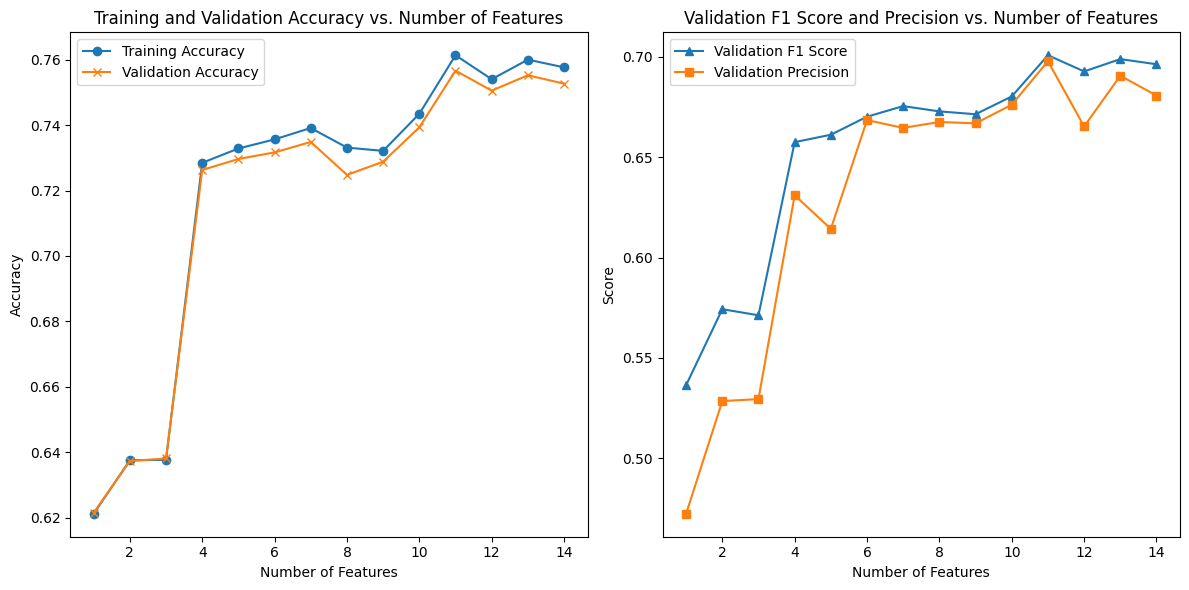

In [66]:
# %%
train_data_NN = train_data_standardized.copy()
val_data_NN = validation_data_standardized.copy()
test_data_NN = train_data_standardized.copy()

# Prepare the data
predictor_cols = train_data_NN.columns.difference(["Claim Injury Type", "Accident Date", "Assembly Date"])

X_train = train_data_NN[predictor_cols]
y_train = train_data_NN["Claim Injury Type"]

X_val = val_data_NN[predictor_cols]
y_val = val_data_NN["Claim Injury Type"]

# Define the total number of features in the dataset
num_features = X_train.shape[1]

# Lists to store the results for plotting
accuracy_scores_train = []
accuracy_scores_val = []
f1_scores_val = []
precision_val = []
num_feature_list = list(range(1, num_features + 1))

# Use LogisticRegression as the base estimator for RFE
base_estimator = LogisticRegression(max_iter=1500)  

# Loop over feature numbers from 1 to the total number of features
for n_features in num_feature_list:
    # Use RFE to select n_features
    rfe = RFE(estimator=base_estimator, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    selected_features = rfe.support_

    # Select the features from training and validation sets
    X_train_rfe = X_train.iloc[:, selected_features]
    X_val_rfe = X_val.iloc[:, selected_features]
    
    # Build the MLPClassifier with a deep structure and small hidden layers
    mlp = MLPClassifier(
        hidden_layer_sizes=(32, 16, 16, 8, 8, 4),  # Deep structure with gradually decreasing sizes
        activation='relu',
        solver='adam',
        max_iter=200
    )

    # Train the MLP model
    mlp.fit(X_train_rfe, y_train)

    # Evaluate on training data
    train_preds = mlp.predict(X_train_rfe)
    accuracy_train = accuracy_score(y_train, train_preds)

    # Evaluate on validation data
    val_preds = mlp.predict(X_val_rfe)
    accuracy_val = accuracy_score(y_val, val_preds)
    f1_val = f1_score(y_val, val_preds, average='weighted')

    # Evaluate precision on validation data
    precision_on_val = precision_score(y_val, val_preds, average='weighted')

    # Store results
    accuracy_scores_train.append(accuracy_train)
    accuracy_scores_val.append(accuracy_val)
    f1_scores_val.append(f1_val)
    precision_val.append(precision_on_val)

    # Get selected feature names
    selected_features_names = X.columns[selected_features]
    # Print results for each feature set
    print(f"Number of features: {n_features}")
    print("Selected features: ", selected_features_names)
    print(f"Training Accuracy: {accuracy_train}")
    print(f"Validation Accuracy: {accuracy_val}")
    print(f"Validation F1 Score: {f1_val}")
    print(f"Validation Precision Score: {precision_on_val}")
    print("-" * 50)

# Plotting accuracy and F1 scores for different feature counts
plt.figure(figsize=(12, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(num_feature_list, accuracy_scores_train, label='Training Accuracy', marker='o')
plt.plot(num_feature_list, accuracy_scores_val, label='Validation Accuracy', marker='x')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Number of Features')
plt.legend()

# Plot Validation F1 Score and Precision
plt.subplot(1, 2, 2)
plt.plot(num_feature_list, f1_scores_val, label='Validation F1 Score', marker='^')
plt.plot(num_feature_list, precision_val, label='Validation Precision', marker='s')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Validation F1 Score and Precision vs. Number of Features')
plt.legend()
plt.tight_layout()
plt.show()




 ## Try four most promising set of features and make Kaggle returns with them

 * Set of features chosen are:
    * 4 features: Chosen since it's the least complex model with no further significant improvements to accuracy. Precision is lacking still.
        * Selected features:  Index(['Attorney/Representative', 'Average Weekly Wage', 'Gender',
       'IME-4 Count'],
      dtype='object')
        * Training Accuracy: 0.7284684362280665
        * Validation Accuracy: 0.72626457438415
        * Validation F1 Score: 0.6575275086779347
        * Validation Precision Score: 0.6310799191921053
    * 6 features: Chosen since precision is higher than with 4 features, while other metrics have stayed quite the same.
        * Selected features:  Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'Carrier Type', 'Gender', 'IME-4 Count'],
      dtype='object')
        * Training Accuracy: 0.7356303354677092
        * Validation Accuracy: 0.7316472341544665
        * Validation F1 Score: 0.6702156648046247
        * Validation Precision Score: 0.6685050147405521
    * 10 features: Chosen for having less complexity than 11 features, and still scoring very near to 11 features' metrics.
        * Selected features:  Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'C-2 Date', 'Carrier Type', 'Days Until Injury Reported',
       'District Name', 'Gender', 'IME-4 Count', 'Industry Code'],
      dtype='object')
        * Training Accuracy: 0.743435491944562
        * Validation Accuracy: 0.7393091961076532
        * Validation F1 Score: 0.6803055465946029
        * Validation Precision Score: 0.6761814996404063
    * 11 features: Chosen for having highest precision, f1-score and accuracy. Most complex model chosen.
        * Selected features:  Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'C-2 Date', 'Carrier Type', 'Days Until Injury Reported',
       'District Name', 'Gender', 'IME-4 Count', 'Industry Code',
       'WCIO Nature of Injury Code'],
      dtype='object')
        * Training Accuracy: 0.7613311800825815
        * Validation Accuracy: 0.7566231261506092
        * Validation F1 Score: 0.7008171200730547
        * Validation Precision Score: 0.6978678333768713

In [68]:
# %%
# Build model with the optimal number of features



train_data_NN = train_data_standardized.copy()
test_data_NN = test_data_standardized.copy()
val_data_NN = validation_data_standardized.copy()

# Prepare the data
predictor_cols_4 = ['Attorney/Representative', 'Average Weekly Wage', 'Gender','IME-4 Count']
predictor_cols_6 = ['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage', 'Carrier Type', 'Gender', 'IME-4 Count']
predictor_cols_10 = ['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date', 'Carrier Type', 'Days Until Injury Reported','District Name', 'Gender', 'IME-4 Count', 'Industry Code']
predictor_cols_11 = ['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage', 'C-2 Date', 'Carrier Type', 'Days Until Injury Reported','District Name', 'Gender', 'IME-4 Count', 'Industry Code','WCIO Nature of Injury Code']


X_4 = train_data_NN[predictor_cols_4]
X_6 = train_data_NN[predictor_cols_6]
X_10 = train_data_NN[predictor_cols_10]
X_11 = train_data_NN[predictor_cols_11]

y_4 = train_data_NN["Claim Injury Type"]
y_6 = train_data_NN["Claim Injury Type"]
y_10 = train_data_NN["Claim Injury Type"]
y_11 = train_data_NN["Claim Injury Type"]

X_val_4 = val_data_NN[predictor_cols_4]
X_val_6 = val_data_NN[predictor_cols_6]
X_val_10 = val_data_NN[predictor_cols_10]
X_val_11 = val_data_NN[predictor_cols_11]

y_val_4 = val_data_NN["Claim Injury Type"]
y_val_6 = val_data_NN["Claim Injury Type"]
y_val_10 = val_data_NN["Claim Injury Type"]
y_val_11 = val_data_NN["Claim Injury Type"]

X_test_4 = test_data_NN[predictor_cols_4]
X_test_6 = test_data_NN[predictor_cols_6]
X_test_10 = test_data_NN[predictor_cols_10]
X_test_11 = test_data_NN[predictor_cols_11]


nn_model_4_features = MLPClassifier(
    hidden_layer_sizes=(32, 16, 16, 8, 8, 4),
    activation='relu',
    solver='adam',
    max_iter=400
)

nn_model_6_features = MLPClassifier(
    hidden_layer_sizes=(32, 16, 16, 8, 8, 4),
    activation='relu',
    solver='adam',
    max_iter=400
)

nn_model_10_features = MLPClassifier(
    hidden_layer_sizes=(32, 16, 16, 8, 8, 4),
    activation='relu',
    solver='adam',
    max_iter=400
)

nn_model_11_features = MLPClassifier(
    hidden_layer_sizes=(32, 16, 16, 8, 8, 4), 
    activation='relu',
    solver='adam',
    max_iter=400  
)


# Train the MLP model
nn_model_4_features.fit(X_4, y_4)
nn_model_6_features.fit(X_6, y_6)
nn_model_10_features.fit(X_10, y_10)
nn_model_11_features.fit(X_11, y_11)

# Evaluate on training data
train_preds_11 = nn_model_11_features.predict(X_11)
accuracy_train_11 = accuracy_score(y_11, train_preds_11)
print(f"Training Accuracy with 11 features (Assembly Date and Accident Date excluded): {accuracy_train_11}")

# Evaluate on validation data
val_preds_11 = nn_model_11_features.predict(X_val_11)
accuracy_val_11 = accuracy_score(y_val_11, val_preds_11)
f1_val_11 = f1_score(y_val_11, val_preds_11, average='weighted')
print(f"Validation Accuracy with 11 features (Assembly Date and Accident Date excluded): {accuracy_val_11}")
print(f"Validation F1 Score with 11 features (Assembly Date and Accident Date excluded): {f1_val_11}")

# Evaluate precision on validation data
precision_val_11 = precision_score(y_val_11, val_preds_11, average='weighted')
print(f"Validation Precision Score with 11 features (Assembly Date and Accident Date excluded): {precision_val_11}")

# Evaluate recall on validation data
recall_val_11 = recall_score(y_val_11, val_preds_11, average='weighted')
print(f"Validation Recall Score with 11 features (Assembly Date and Accident Date excluded): {recall_val_11}")

# Same for 10 features


train_preds_10 = nn_model_10_features.predict(X_10)
accuracy_train_10 = accuracy_score(y_10, train_preds_10)
print(f"Training Accuracy with 10 features: {accuracy_train_10}")

val_preds_10 = nn_model_10_features.predict(X_val_10)
accuracy_val_10 = accuracy_score(y_val_10, val_preds_10)
f1_val_10 = f1_score(y_val_10, val_preds_10, average='weighted')
print(f"Validation Accuracy with 10 features: {accuracy_val_10}")
print(f"Validation F1 Score with 10 features: {f1_val_10}")

precision_val_10 = precision_score(y_val_10, val_preds_10, average='weighted')
print(f"Validation Precision Score with 10 features: {precision_val_10}")

recall_val_10 = recall_score(y_val_10, val_preds_10, average='weighted')
print(f"Validation Recall Score with 10 features: {recall_val_10}")

# Same for 6 features

train_preds_6 = nn_model_6_features.predict(X_6)
accuracy_train_6 = accuracy_score(y_6, train_preds_6)
print(f"Training Accuracy with 6 features: {accuracy_train_6}")

val_preds_6 = nn_model_6_features.predict(X_val_6)
accuracy_val_6 = accuracy_score(y_val_6, val_preds_6)
f1_val_6 = f1_score(y_val_6, val_preds_6, average='weighted')
print(f"Validation Accuracy with 6 features: {accuracy_val_6}")
print(f"Validation F1 Score with 6 features: {f1_val_6}")

precision_val_6 = precision_score(y_val_6, val_preds_6, average='weighted')
print(f"Validation Precision Score with 6 features: {precision_val_6}")

recall_val_6 = recall_score(y_val_6, val_preds_6, average='weighted')
print(f"Validation Recall Score with 6 features: {recall_val_6}")


# Same for 4 features

train_preds_4 = nn_model_4_features.predict(X_4)
accuracy_train_4 = accuracy_score(y_4, train_preds_4)
print(f"Training Accuracy with 4 features: {accuracy_train_4}")

val_preds_4 = nn_model_4_features.predict(X_val_4)
accuracy_val_4 = accuracy_score(y_val_4, val_preds_4)
f1_val_4 = f1_score(y_val_4, val_preds_4, average='weighted')
print(f"Validation Accuracy with 4 features: {accuracy_val_4}")
print(f"Validation F1 Score with 4 features: {f1_val_4}")

precision_val_4 = precision_score(y_val_4, val_preds_4, average='weighted')
print(f"Validation Precision Score with 4 features: {precision_val_4}")

recall_val_4 = recall_score(y_val_4, val_preds_4, average='weighted')
print(f"Validation Recall Score with 4 features: {recall_val_4}")



Training Accuracy with 11 features (Assembly Date and Accident Date excluded): 0.7580967739743558
Validation Accuracy with 11 features (Assembly Date and Accident Date excluded): 0.7542912246865959
Validation F1 Score with 11 features (Assembly Date and Accident Date excluded): 0.694952808116087
Validation Precision Score with 11 features (Assembly Date and Accident Date excluded): 0.689776557653298
Validation Recall Score with 11 features (Assembly Date and Accident Date excluded): 0.7542912246865959


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Accuracy with 10 features: 0.752669857282963
Validation Accuracy with 10 features: 0.7486017357762778
Validation F1 Score with 10 features: 0.6887987896592884
Validation Precision Score with 10 features: 0.6788981807629099
Validation Recall Score with 10 features: 0.7486017357762778


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Accuracy with 6 features: 0.7284435213350758
Validation Accuracy with 6 features: 0.724081704216709
Validation F1 Score with 6 features: 0.6636175910568306
Validation Precision Score with 6 features: 0.6641785536381373
Validation Recall Score with 6 features: 0.724081704216709


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Accuracy with 4 features: 0.7311207398364225
Validation Accuracy with 4 features: 0.7293153326904532
Validation F1 Score with 4 features: 0.6661257457716961
Validation Precision Score with 4 features: 0.651754579784549
Validation Recall Score with 4 features: 0.7293153326904532


/Users/onnimansikkamaki/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [69]:
# %%
# Save models

# Save the models
joblib.dump(nn_model_11_features, 'nn_model_11_features_no_assembly_nor_accident_date.pkl')
joblib.dump(nn_model_10_features, 'nn_model_10_features_no_assembly_nor_accident_date.pkl')
joblib.dump(nn_model_6_features, 'nn_model_6_features_no_assembly_nor_accident_date.pkl')
joblib.dump(nn_model_4_features, 'nn_model_4_features_no_assembly_nor_accident_date.pkl')


['nn_model_4_features_no_assembly_nor_accident_date.pkl']

In [79]:
# %%
# Get predictions for the test data with all models
test_preds_4 = nn_model_4_features.predict(X_test_4)
test_preds_6 = nn_model_6_features.predict(X_test_6)
test_preds_10 = nn_model_10_features.predict(X_test_10)
test_preds_11 = nn_model_11_features.predict(X_test_11)

# See the unique values in the predictions
unique_values = np.unique(test_preds_11)
print(unique_values)

unique_values_10 = np.unique(test_preds_10)
print(unique_values_10)

unique_values_6 = np.unique(test_preds_6)
print(unique_values_6)

unique_values_4 = np.unique(test_preds_4)
print(unique_values_4)

# Format the predictions according to the required label format
formatted_predictions_11 = [claim_injury_type_mapping[str(pred)] for pred in test_preds_11]
formatted_predictions_10 = [claim_injury_type_mapping[str(pred)] for pred in test_preds_10]
formatted_predictions_6 = [claim_injury_type_mapping[str(pred)] for pred in test_preds_6]
formatted_predictions_4 = [claim_injury_type_mapping[str(pred)] for pred in test_preds_4]

# Create the submission DataFrames
submission_11 = pd.DataFrame({
    "Claim Identifier": test_data_standardized.index,
    "Claim Injury Type": formatted_predictions_11
})

submission_10 = pd.DataFrame({
    "Claim Identifier": test_data_standardized.index,
    "Claim Injury Type": formatted_predictions_10
})

submission_6 = pd.DataFrame({
    "Claim Identifier": test_data_standardized.index,
    "Claim Injury Type": formatted_predictions_6
})

submission_4 = pd.DataFrame({
    "Claim Identifier": test_data_standardized.index,
    "Claim Injury Type": formatted_predictions_4
})



# Save to CSV in the required format
submission_11.to_csv("Group39__Version18.csv", index=False)
submission_10.to_csv("Group39__Version19.csv", index=False)
submission_6.to_csv("Group39__Version20.csv", index=False)
submission_4.to_csv("Group39__Version21.csv", index=False)

# Check length of the submission files
print(len(submission_11))
print(len(submission_10))
print(len(submission_6))
print(len(submission_4))


[1 2 3 4 5]
[1 2 3 4 5]
[1 2 3 4 5]
[2 3 4 5]
387975
387975
387975
387975


 ## Results in Kaggle:
 * 11 features: 0.13038
 * 10 features: 0.11569
 * 6 features: 0.21350
 * 4 features: 0.2606

 ## OUTDATED!: (CODE ABOUT SMOTE COMMENTED OUT AND TRIED AFTER IMPORTANT FIXING OF PREPROCESSING )Further NN Model Experiments: Target value imbalance

 * Train model inside RFE and then with 3 best sets of features found this far (according to local environment assessment as well as Kaggle competition f1 score)

     * Before training, apply Oversampling, Undersampling or SMOTE Techniques to get more minority result class values to the training. Our model is probably not good in predicting for those minoriity target variable value classes.

 * Training iterations of predictor features:

     * Inside RFE to find best set of features:

         * Inside RFE without assembly and accident date

     * Predict for two best sets from both RFE procesure above

     * Best 3 sets of previous experiments:

         * See if modifications to SMOTE are needed





 ## Chosen method: Creating synthetic minority class data with SMOTE

 * We chose SMOTE and not oversampling, since duplicating minority class members a lot, we might add risk for overfitting

In [ ]:
# %%
# # Check the target value counts in train data
# train_data_balanced = train_data_non_standardized.copy()


# train_data_balanced['Claim Injury Type'].value_counts()


# # Prepare the data
# predictor_cols = train_data_balanced.columns[train_data_balanced.columns != "Claim Injury Type"]
# X = train_data_balanced[predictor_cols]
# y = train_data_balanced["Claim Injury Type"]

# # Scale the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)


# # We set a custom sampling strategy to reduce the amount of created syntetic samples and to keep the size of dataset OK 
# # From value count we saw that Majority class has 282253 samples. For minority classes that have less than 25% of the majority class samples are 3,5,1,6,8 and 7. For those classes we will set the sampling strategy to 0.25
# # So we are adding synthetic samples to minority classes to have 25% of the majority class samples

# """
# value counts
# 2    282253
# 4    141022
# 3     67250
# 5     46867
# 1     10058
# 6      3945
# 8       431
# 7        69
# """

# target_size = int(0.25 * 282253)

# # Define sampling strategy as a dictionary
# # Only include classes with fewer samples than target_size (70563). 
# sampling_strategy = {
#     3: target_size,  # Currently 67250 -> Increase to 70563
#     5: target_size,  # Currently 46867 -> Increase to 70563
#     1: target_size,  # Currently 10058 -> Increase to 70563
#     6: target_size,  # Currently 3945 -> Increase to 70563
#     7: target_size,  # Currently 69 -> Increase to 70563
#     8: target_size,  # Currently 431 -> Increase to 70563
# }



# # Apply SMOTE 
# smote = SMOTE(sampling_strategy=sampling_strategy, random_state=5)
# X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# # Convert the resampled data back to a DataFrame
# X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
# y_resampled_df = pd.DataFrame(y_resampled, columns=['Claim Injury Type'])
# train_data_resampled = pd.concat([X_resampled_df, y_resampled_df], axis=1)

# # Check for lenght of data and value counts in the resampled data
# print(len(train_data_resampled))
# train_data_resampled['Claim Injury Type'].value_counts()




 ## Model Training with new balanced training data

In [ ]:
# %%
# # RFE WITH ALL FEATURES (for SMOTE'd data)

# train_data_NN = train_data_resampled.copy()
# test_data_NN  = test_data_non_standardized.copy()


# # Prepare the data
# predictor_cols = train_data_NN.columns.difference(["Claim Injury Type", "Accident Date", "Assembly Date"])
# X = train_data_NN[predictor_cols]
# y = train_data_NN["Claim Injury Type"]


# # Split data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=5, stratify=y)

# # Define the total number of features in the dataset
# num_features = X.shape[1]





In [ ]:
# %%

# # Lists to store the results for plotting
# accuracy_scores_train = []
# accuracy_scores_val = []
# f1_scores_val = []
# num_feature_list = list(range(1, num_features + 1))

# # Use LogisticRegression as the base estimator for RFE
# base_estimator = LogisticRegression(max_iter=1000)  

# # Loop over feature numbers from 1 to the total number of features
# for n_features in num_feature_list:
#     # Use RFE to select n_features
#     rfe = RFE(estimator=base_estimator, n_features_to_select=n_features)
#     rfe.fit(X_train, y_train)
#     selected_features = rfe.support_

#     #NOTE: THIS FOR NUMPY!
#     # Select the features from training and validation sets
#     # X_train_rfe = X_train[:, selected_features]
#     # X_val_rfe = X_val[:, selected_features]

#     #NOTE: THIS FOR DATAFRAMES!
#     selected_columns = X_train.columns[selected_features] # Get the selected column names
#     X_train_rfe = X_train[selected_columns]
#     X_val_rfe = X_val[selected_columns]

    
#     # Build the MLPClassifier with a deep structure and small hidden layers
#     mlp = MLPClassifier(
#         hidden_layer_sizes=(32, 16, 16, 8, 8, 4),  # Deep structure with gradually decreasing sizes
#         activation='relu',
#         solver='adam',
#         max_iter=200  
#     )

#     # Train the MLP model
#     mlp.fit(X_train_rfe, y_train)

#     # Evaluate on training data
#     train_preds = mlp.predict(X_train_rfe)
#     accuracy_train = accuracy_score(y_train, train_preds)

#     # Evaluate on validation data
#     val_preds = mlp.predict(X_val_rfe)
#     accuracy_val = accuracy_score(y_val, val_preds)
#     f1_val = f1_score(y_val, val_preds, average='weighted')

#     # Store results
#     accuracy_scores_train.append(accuracy_train)
#     accuracy_scores_val.append(accuracy_val)
#     f1_scores_val.append(f1_val)

#     # Get selected feature names
#     selected_features_names = selected_columns
#     # Print results for each feature set
#     print(f"Number of features: {n_features}")
#     print("Selected features: ", selected_features_names)
#     print(f"Training Accuracy: {accuracy_train}")
#     print(f"Validation Accuracy: {accuracy_val}")
#     print(f"Validation F1 Score: {f1_val}")
#     print("-" * 50)

# # Plotting accuracy and F1 scores for different feature counts
# plt.figure(figsize=(12, 6))

# # Plot Training and Validation Accuracy
# plt.subplot(1, 2, 1)
# plt.plot(num_feature_list, accuracy_scores_train, label='Training Accuracy', marker='o')
# plt.plot(num_feature_list, accuracy_scores_val, label='Validation Accuracy', marker='x')
# plt.xlabel('Number of Features')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy vs. Number of Features')
# plt.legend()

# # Plot Validation F1 Score
# plt.subplot(1, 2, 2)
# plt.plot(num_feature_list, f1_scores_val, label='Validation F1 Score', marker='^')
# plt.xlabel('Number of Features')
# plt.ylabel('F1 Score')
# plt.title('Validation F1 Score vs. Number of Features')
# plt.legend()

# plt.tight_layout()
# plt.show()




 Next we will train models with 4 most promising set of features with even more iterations allowed for the NN and save the model.

 * Set 1: Three features: ['Attorney/Representative', 'IME-4 Count', 'WCIO Nature of Injury Code']

     * We want to explore this since it was the first set of features that pumped up the accuracy radically

 * Set 2: Nine features: ['Age at Injury', 'Attorney/Representative', 'C-2 Date', 'Days Until Injury Reported', 'Gender', 'IME-4 Count', 'Industry Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']

     * We want to explore this since it was the set of features, which after, we didn't significally prove accuracy or f1-score

 * Set 3: Thirteen features: All but Assemly Date and Age at Injury

     * We want to explore this since it was the set that produced overall highest accuracies and f1-scores

 * Set 4: All the features that improved training and validation accracy and f1-score:

     * Selected features: ['Age at Injury', 'Attorney/Representative', 'C-2 Date', 'Days Until Injury Reported', 'IME-4 Count', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Carrier Type']

     * We want to explore this since we want to try how the result comes up with only the features that improved the metrics from the previous iteration of RFE process

In [ ]:
# %%
# # Apply smote to all datasets

# # Check the target value counts in train data
# train_data_balanced = train_data_non_standardized.copy()
# test_data_balanced = test_data_non_standardized.copy()

# # Prepare the data
# predictor_cols_all = train_data_NN.columns.difference(["Claim Injury Type", "Accident Date", "Assembly Date"])
# predictor_cols_3 = ['Attorney/Representative', 'IME-4 Count', 'WCIO Nature of Injury Code'] 
# predictor_cols_9 = ['Age at Injury', 'Attorney/Representative', 'C-2 Date', 'Days Until Injury Reported', 'Gender', 'IME-4 Count', 'Industry Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']
# predictor_cols_improved = ['Age at Injury', 'Attorney/Representative', 'C-2 Date', 'Days Until Injury Reported', 'IME-4 Count', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Carrier Type']


# X_all = train_data_NN[predictor_cols_all]
# X_3 = train_data_NN[predictor_cols_3]
# X_9 = train_data_NN[predictor_cols_9]
# X_improved = train_data_NN[predictor_cols_improved]

# y_all = train_data_NN["Claim Injury Type"]
# y_3 = train_data_NN["Claim Injury Type"]
# y_9 = train_data_NN["Claim Injury Type"]
# y_improved = train_data_NN["Claim Injury Type"]



# # Scale the data
# scaler_all = StandardScaler()
# scaler_3 = StandardScaler()
# scaler_9 = StandardScaler()
# scaler_improved = StandardScaler()

# X_scaled_all = scaler_all.fit_transform(X_all)
# X_scaled_3 = scaler_3.fit_transform(X_3)
# X_scaled_9 = scaler_9.fit_transform(X_9)
# X_scaled_improved = scaler_improved.fit_transform(X_improved)

# # Prepeare test data
# test_data_NN_all = test_data_NN[predictor_cols_all]
# test_data_NN_3 = test_data_NN[predictor_cols_3]
# test_data_NN_9 = test_data_NN[predictor_cols_9]
# test_data_NN_improved = test_data_NN[predictor_cols_improved]

# # Scale the test data
# test_data_NN_all = scaler_all.transform(test_data_NN_all)
# test_data_NN_3 = scaler_3.transform(test_data_NN_3)
# test_data_NN_9 = scaler_9.transform(test_data_NN_9)
# test_data_NN_improved = scaler_improved.transform(test_data_NN_improved)

# # We set a custom sampling strategy to reduce the amount of created syntetic samples and to keep the size of dataset OK 
# # From value count we saw that Majority class has 282253 samples. For minority classes that have less than 25% of the majority class samples are 3,5,1,6,8 and 7. For those classes we will set the sampling strategy to 0.25
# # So we are adding synthetic samples to minority classes to have 25% of the majority class samples

# """
# value counts
# 2    282253
# 4    141022
# 3     67250
# 5     46867
# 1     10058
# 6      3945
# 8       431
# 7        69
# """

# target_size = int(0.25 * 282253)

# # Define sampling strategy as a dictionary
# # Only include classes with fewer samples than target_size (70563). 
# sampling_strategy = {
#     3: target_size,  # Currently 67250 -> Increase to 70563
#     5: target_size,  # Currently 46867 -> Increase to 70563
#     1: target_size,  # Currently 10058 -> Increase to 70563
#     6: target_size,  # Currently 3945 -> Increase to 70563
#     7: target_size,  # Currently 69 -> Increase to 70563
#     8: target_size,  # Currently 431 -> Increase to 70563
# }



# # Apply SMOTE 
# smote_all = SMOTE(sampling_strategy=sampling_strategy, random_state=5)
# smote_3 = SMOTE(sampling_strategy=sampling_strategy, random_state=5)
# smote_9 = SMOTE(sampling_strategy=sampling_strategy, random_state=5)
# smote_improved = SMOTE(sampling_strategy=sampling_strategy, random_state=5)

# X_resampled_all, y_resampled_all = smote_all.fit_resample(X_scaled_all, y_all)
# X_resampled_3, y_resampled_3 = smote_3.fit_resample(X_scaled_3, y_3)
# X_resampled_9, y_resampled_9 = smote_9.fit_resample(X_scaled_9, y_9)
# X_resampled_improved, y_resampled_improved = smote_improved.fit_resample(X_scaled_improved, y_improved)

# # Convert the resampled data back to a DataFrame

# X_resampled_all_df = pd.DataFrame(X_resampled_all, columns=X_all.columns)
# y_resampled_all_df = pd.DataFrame(y_resampled_all, columns=['Claim Injury Type'])
# train_data_resampled_all = pd.concat([X_resampled_all_df, y_resampled_all_df], axis=1)

# X_resampled_3_df = pd.DataFrame(X_resampled_3, columns=X_3.columns)
# y_resampled_3_df = pd.DataFrame(y_resampled_3, columns=['Claim Injury Type'])
# train_data_resampled_3 = pd.concat([X_resampled_3_df, y_resampled_3_df], axis=1)

# X_resampled_9_df = pd.DataFrame(X_resampled_9, columns=X_9.columns)
# y_resampled_9_df = pd.DataFrame(y_resampled_9, columns=['Claim Injury Type'])
# train_data_resampled_9 = pd.concat([X_resampled_9_df, y_resampled_9_df], axis=1)

# X_resampled_improved_df = pd.DataFrame(X_resampled_improved, columns=X_improved.columns)
# y_resampled_improved_df = pd.DataFrame(y_resampled_improved, columns=['Claim Injury Type'])
# train_data_resampled_improved = pd.concat([X_resampled_improved_df, y_resampled_improved_df], axis=1)



# # Check for lenght of data and value counts in the resampled data
# print(len(train_data_resampled_all))
# print(len(train_data_resampled_3))
# print(len(train_data_resampled_9))
# print(len(train_data_resampled_improved))

# print(train_data_resampled_all['Claim Injury Type'].value_counts())
# print(train_data_resampled_3['Claim Injury Type'].value_counts())
# print(train_data_resampled_9['Claim Injury Type'].value_counts())
# print(train_data_resampled_improved['Claim Injury Type'].value_counts())




In [ ]:
# %%
# # Split data into training and validation sets
# X_resampled_all_df = train_data_resampled_all[predictor_cols_all]
# y_resampled_all_df = train_data_resampled_all["Claim Injury Type"]
# X_train_all, X_val_all, y_train_all, y_val_all = train_test_split(X_resampled_all_df, y_resampled_all_df, test_size=0.2, random_state=5, stratify=y_resampled_all_df)

# X_resampled_3_df = train_data_resampled_3[predictor_cols_3]
# y_resampled_3_df = train_data_resampled_3["Claim Injury Type"]
# X_train_3, X_val_3, y_train_3, y_val_3 = train_test_split(X_resampled_3_df, y_resampled_3_df, test_size=0.2, random_state=5, stratify=y_resampled_3_df)

# X_resampled_9_df = train_data_resampled_9[predictor_cols_9]
# y_resampled_9_df = train_data_resampled_9["Claim Injury Type"]
# X_train_9, X_val_9, y_train_9, y_val_9 = train_test_split(X_resampled_9_df, y_resampled_9_df, test_size=0.2, random_state=5, stratify=y_resampled_9_df)

# X_resampled_improved_df = train_data_resampled_improved[predictor_cols_improved]
# y_resampled_improved_df = train_data_resampled_improved["Claim Injury Type"]
# X_train_improved, X_val_improved, y_train_improved, y_val_improved = train_test_split(X_resampled_improved_df, y_resampled_improved_df, test_size=0.2, random_state=5, stratify=y_resampled_improved_df)


# # Define the total number of features in the dataset
# num_features_all = X_resampled_all_df.shape[1]
# num_features_3 = X_resampled_3_df.shape[1]
# num_features_9 = X_resampled_9_df.shape[1]
# num_features_improved = X_resampled_improved_df.shape[1]



In [ ]:
# %%
# # Train model with all features with more iterations
# nn_model_all_features = MLPClassifier(
#     hidden_layer_sizes=(32, 16, 16, 8, 8, 4), 
#     activation='relu',
#     solver='adam',
#     max_iter=300  
# )

# # Train the MLP model
# nn_model_all_features.fit(X_train_all, y_train_all)

# # Evaluate on training data
# train_preds_all = nn_model_all_features.predict(X_train_all)
# accuracy_train_all = accuracy_score(y_train_all, train_preds_all)
# print(f"Training Accuracy with all features (Other than Assembly and Accident Date): {accuracy_train_all}")

# # Evaluate on validation data
# val_preds_all = nn_model_all_features.predict(X_val_all)
# accuracy_val_all = accuracy_score(y_val_all, val_preds_all)
# f1_val_all = f1_score(y_val_all, val_preds_all, average='weighted')
# print(f"Validation Accuracy with all features (Other than Assembly and Accident Date): {accuracy_val_all}")
# print(f"Validation F1 Score with all features (Other than Assembly and Accident Date): {f1_val_all}")

# # Evaluate precision on validation data
# precision_val_all = precision_score(y_val_all, val_preds_all, average='weighted')
# print(f"Validation Precision Score with all features (Other than Assembly and Accident Date): {precision_val_all}")

# # Save the model
# joblib.dump(nn_model_all_features, 'nn_model_all_features_smote.pkl')


In [ ]:
# %%
# # Train model with 3 features with more iterations
# nn_model_3_features = MLPClassifier(
#     hidden_layer_sizes=(32, 16, 16, 8, 8, 4), 
#     activation='relu',
#     solver='adam',
#     max_iter=300  
# )

# # Train the MLP model
# nn_model_3_features.fit(X_train_3, y_train_3)

# # Evaluate on training data
# train_preds_3 = nn_model_3_features.predict(X_train_3)
# accuracy_train_3 = accuracy_score(y_train_3, train_preds_3)
# print(f"Training Accuracy with 3 features: {accuracy_train_3}")

# # Evaluate on validation data
# val_preds_3 = nn_model_3_features.predict(X_val_3)
# accuracy_val_3 = accuracy_score(y_val_3, val_preds_3)
# f1_val_3 = f1_score(y_val_3, val_preds_3, average='weighted')
# print(f"Validation Accuracy with 3 features: {accuracy_val_3}")
# print(f"Validation F1 Score with 3 features: {f1_val_3}")

# # Evaluate precision on validation data
# precision_val_3 = precision_score(y_val_3, val_preds_3, average='weighted')
# print(f"Validation Precision Score with 3 features: {precision_val_3}")

# # Save model with 3 features
# joblib.dump(nn_model_3_features, 'nn_model_3_features_smote.pkl')


In [ ]:
# %%
# # Train model with 9 features with more iterations
# nn_model_9_features = MLPClassifier(
#     hidden_layer_sizes=(32, 16, 16, 8, 8, 4), 
#     activation='relu',
#     solver='adam',
#     max_iter=300  
# )

# # Train the MLP model
# nn_model_9_features.fit(X_train_9, y_train_9)

# # Evaluate on training data
# train_preds_9 = nn_model_9_features.predict(X_train_9)
# accuracy_train_9 = accuracy_score(y_train_9, train_preds_9)
# print(f"Training Accuracy with 9 features: {accuracy_train_9}")

# # Evaluate on validation data
# val_preds_9 = nn_model_9_features.predict(X_val_9)
# accuracy_val_9 = accuracy_score(y_val_9, val_preds_9)
# f1_val_9 = f1_score(y_val_9, val_preds_9, average='weighted')

# print(f"Validation Accuracy with 9 features: {accuracy_val_9}")
# print(f"Validation F1 Score with 9 features: {f1_val_9}")

# # Evaluate precision on validation data
# precision_val_9 = precision_score(y_val_9, val_preds_9, average='weighted')
# print(f"Validation Precision Score with 9 features: {precision_val_9}")

# # Save model with 9 features
# joblib.dump(nn_model_9_features, 'nn_model_9_features_smote.pkl')


In [ ]:
# %%
# # Train model with improved features with more iterations
# nn_model_improved_features = MLPClassifier(
#     hidden_layer_sizes=(32, 16, 16, 8, 8, 4), 
#     activation='relu',
#     solver='adam',
#     max_iter=300  
# )

# # Train the MLP model
# nn_model_improved_features.fit(X_train_improved, y_train_improved)

# # Evaluate on training data
# train_preds_improved = nn_model_improved_features.predict(X_train_improved)

# accuracy_train_improved = accuracy_score(y_train_improved, train_preds_improved)
# print(f"Training Accuracy with improved features: {accuracy_train_improved}")

# # Evaluate on validation data
# val_preds_improved = nn_model_improved_features.predict(X_val_improved)
# accuracy_val_improved = accuracy_score(y_val_improved, val_preds_improved)
# f1_val_improved = f1_score(y_val_improved, val_preds_improved, average='weighted')

# print(f"Validation Accuracy with improved features: {accuracy_val_improved}")
# print(f"Validation F1 Score with improved features: {f1_val_improved}")

# # Evaluate precision on validation data
# precision_val_improved = precision_score(y_val_improved, val_preds_improved, average='weighted')
# print(f"Validation Precision Score with improved features: {precision_val_improved}")

# # Save model with improved features
# joblib.dump(nn_model_improved_features, 'nn_model_improved_features_smote.pkl')


In [ ]:
# %%
# # Get predictions for the test data with all models
# test_preds_all = nn_model_all_features.predict(test_data_NN_all)
# test_preds_3 = nn_model_3_features.predict(test_data_NN_3)
# test_preds_9 = nn_model_9_features.predict(test_data_NN_9)
# test_preds_improved = nn_model_improved_features.predict(test_data_NN_improved)


# # See the unique values in the predictions
# unique_values_all = np.unique(test_preds_all)
# print(unique_values_all)

# unique_values_3 = np.unique(test_preds_3)
# print(unique_values_3)

# unique_values_9 = np.unique(test_preds_9)
# print(unique_values_9)

# unique_values_improved = np.unique(test_preds_improved)
# print(unique_values_improved)

# # Format the predictions according to the required label format
# formatted_predictions_all = [claim_injury_type_mapping[pred] for pred in test_preds_all]
# formatted_predictions_3 = [claim_injury_type_mapping[pred] for pred in test_preds_3]
# formatted_predictions_9 = [claim_injury_type_mapping[pred] for pred in test_preds_9]
# formatted_predictions_improved = [claim_injury_type_mapping[pred] for pred in test_preds_improved]

# # Create the submission DataFrames
# submission_all = pd.DataFrame({
#     "Claim Identifier": test_data.index,
#     "Claim Injury Type": formatted_predictions_all
# })

# submission_3 = pd.DataFrame({
#     "Claim Identifier": test_data.index,
#     "Claim Injury Type": formatted_predictions_3
# })

# submission_9 = pd.DataFrame({
#     "Claim Identifier": test_data.index,
#     "Claim Injury Type": formatted_predictions_9
# })

# submission_improved = pd.DataFrame({
#     "Claim Identifier": test_data.index,
#     "Claim Injury Type": formatted_predictions_improved
# })

# # Save to CSV in the required format
# submission_all.to_csv("Group39__Version05.csv", index=False)
# submission_3.to_csv("Group39__Version06.csv", index=False)
# submission_9.to_csv("Group39__Version07.csv", index=False)
# submission_improved.to_csv("Group39__Version08.csv", index=False)


# # Check length of the submission files
# print(len(submission_all))
# print(len(submission_3))
# print(len(submission_9))
# print(len(submission_improved))


In [ ]:
# %%
# #See the unique values in the submission files
# print(submission_all['Claim Injury Type'].value_counts())
# print(submission_3['Claim Injury Type'].value_counts())
# print(submission_9['Claim Injury Type'].value_counts())
# print(submission_improved['Claim Injury Type'].value_counts())


 ## (POOR RESULTS AND CODE COMMENTED OUT)Results with Smote and RFE

 * 3 features

     * Accuracy val data: 0.591

     * f1-score val data: 0.547

     * f1-score kaggle: 0.00...

     * NOTE: ONLY MINORITY CLASSES IN PREDICTIONS!! We don't trust this set of features at all to be good predicctors for target **on their own**

 * 9 features

     * Accuracy val data: 0.656

     * f1-score val data: 0.612

     * f1-score kaggle: 0.15

 * All features

     * Accuracy val data: 0.670

     * f1-score val data: 0.629

     * f1-score kaggle: 0.13

 * 10 ("improved") features

     * Accuracy val data: 0.665

     * f1-score val data: 0.623

     * f1-score kaggle:





 ## Addition of Average Weekly Wage back to model
 
 #### Code before wage is not visible, we added wage back in preprocessing and modified the same codes

 * Team member (and before this line also we) found out that this makes the f1-score better and seems to be very important feature.
 * This improved NN models a lot even though they are still poor

 ## Further NN Model Experiment: Change RFE to Decision Tree RFE instead of Logistic Regression RFE

In [ ]:
# %%



## RFE DT vs. Logistic Regression: Feature importances

* With Logistic Regression RFE best results are given by these features:
    * 
* With DT RFE best results are given by these features: 
    *

* Based on these two different base model RFE methods, let's try to build a model with these features:
    *
    *

In [ ]:
#TODO:

 ## SMOTE/Oversampling tried again.

* **First time we tried this, we scaled data before applying SMOTE. This is wrong order and can lead to distorted synthetic samples**
 
 * Last time (also last time we tried, we didn't have wage column and also we potentially had leaky data preprocessing process) we tried SMOTE, it wasn't successcull. After less leaky data preprocessing, experimenting with different RFE methods and hyperparameter tuning, lets

 * We still have minority class members underpresneted

In [ ]:
# %%
#TODO:


## NN Model: One-Hot Encoding: 
* We try to apply one-hot encoding for categorical variables since now we have quite high numbers in few of the categorial features. These higher values compared to values in scaled numerical values might dominate in training

In [ ]:
#TODO:

 ## NN Model: Hyperparameter Tuning and other experiments

 * Try Robust scaler (from ML practicals: Neural Networks) for data instead of standard scaler

 * NOTE: **(IS THIS SUITABLE AFTER OUR HOLD-OUT METHOD?)** GridSearchCV

 * Batching

 * Hyperaparameter Tuning

     * Layer tuning

     * Solver tuning

     * Max iteration tuning

     * Activation function tuning

     * Other...

#### Robust Scaler

In [ ]:
# %%
#TODO:

#### NOTE: **(IS THIS SUITABLE AFTER OUR HOLD-OUT METHOD?)** GridSearchCV

In [ ]:
#TODO: MAYBE!!

#### Batching

In [ ]:
#TODO:

#### Model hyperparameter tuning: Shallower Neural Network

In [ ]:
#TODO:

#### Model hyperparameter tuning: Deeper Neural Network

In [ ]:
#TODO:

#### Model hyperparameter tuning: Try softmax activation function

In [ ]:
#TODO:

#### Model hyperparameter tuning: Test different solvers (adman, sgd and lbfgs) with high max_iter

In [ ]:
#TODO:

 ## NN Model: Final Assessment and results

 * See precision, recall, f1-score, training and testing accuracy and confusion matrix and assess the quality of the model.